In [1]:
import os 
from random import randint
from datetime import datetime
from pyvi import ViTokenizer
from gensim import corpora, matutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import pickle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, svm
from sklearn.model_selection import GridSearchCV, KFold
import gensim
import gensim.downloader as gensim_api

from file_loader import FileStore, FileReader, DataLoader
from preprocessing import *
import const

# Preprocessing

In [2]:
dataLoader = DataLoader(const.DATA_PATH)
data = dataLoader.get_json()

fileReader = FileReader('./data/vietnamese-stopwords.txt')
stopwordLst = fileReader.read_stopwords()

In [3]:
len(data)

33759

In [4]:
data[0]

{'category': 'Van hoa',
 'content': '\ufeff Ông đồ cuối cùng trên đảo\n“Vua Tần cỡi cọp chơi tám cõi Trời xanh, kiếm quang sáng chói ... Tiên nhân cầm đuốc khói nhẹ nhàng Mắt say nhòa lệ theo cung đàn”. \nNgồi trên bãi biển lộng gió, ông đồ Võ Hiển Đạt bất ngờ đọc cho tôi nghe bài Tần vương ẩm tửu của Lý Hạ, người được mệnh danh là “thi quỉ” đời Đường, tiếng tăm và tác phẩm truyền lưu hậu thế không thua kém “thi tiên” Lý Bạch, “thi Phật” Vương Duy, “thi thánh” Đỗ Phủ. Rồi ông tâm sự: “Tôi sinh ra nhằm lúc Nho học mạt vận, may mắn được học dăm chữ thánh hiền. Bây giờ, thỉnh thoảng tôi chỉ còn dùng mớ chữ nghĩa một thời vang bóng này khi có bạn tâm giao hoặc ai đó nhờ viết câu đối xưa”. \nMen theo con đường bãi biển rợp bóng dừa xanh, tôi về nhà ông ở thôn Tây, xã An Vĩnh, huyện đảo Lý Sơn (Quảng Ngãi). Thời gian như dừng lại trong ngôi nhà cổ của ông đồ cuối cùng ở hòn đảo này. Những bức hoành phi, câu đối được viết bằng mực tàu, bút lông nét chữ như rồng múa phượng bay treo từ hàng cột

In [5]:
processing(data[0]['content'], stopwordLst)

'đồ đảo vua tần cỡi cọp tám cõi trời xanh kiếm quang chói tiên_nhân cầm đuốc khói nhẹ_nhàng mắt say nhòa lệ cung đàn bãi biển lộng_gió đồ võ hiển đọc tần vương ẩm tửu lý hạ mệnh_danh thi quỉ đời đường tiếng_tăm tác_phẩm truyền lưu hậu_thế thua_kém thi tiên lý bạch thi phật vương thi thánh đỗ_phủ tâm_sự sinh nho_học mạt_vận may_mắn học dăm chữ thánh_hiền mớ chữ_nghĩa thời vang bóng tâm_giao viết câu_đối xưa men đường bãi biển rợp bóng dừa xanh thôn tây xã an vĩnh huyện đảo lý sơn quảng_ngãi dừng cổ đồ hòn đảo hoành_phi câu_đối viết mực_tàu bút_lông nét chữ rồng múa phượng bay treo hàng cột bờ hiên tận bàn_thờ tổ_tiên gian sập gụ trải trăm bóng_nước xếp_bằng đọc sách múa bút chữ trang_trọng cổ tủ gỗ lim ấm mùi nhang trầm phảng_phất hàng linh vị thờ vị tổ_tiên bút đồ khắp đảo lý sơn biển lý sơn tình_cờ đồ võ hiển chứng_kiến an_táng nghi_lễ mộ gió ngư_dân bất_hạnh gửi xác đại_dương thi_hài quan_tài hình_nhân đất_sét lễ_nghi nghiêm linh tụng kinh cờ phướn cầu_siêu đi mãi_mãi cán_bộ văn_phòn

In [5]:
features = []
labels = []

In [6]:
for d in data:
    features.append(d['content'])
    labels.append(d['category'])

In [7]:
label_dict = dict(
                    zip(
                        sorted(set(labels), key=labels.index), 
                        range(len(labels))
                        )
                )

In [8]:
label_dict

{'Van hoa': 0,
 'The gioi': 1,
 'Khoa hoc': 2,
 'Suc khoe': 3,
 'Chinh tri Xa hoi': 4,
 'Vi tinh': 5,
 'Kinh doanh': 6,
 'The thao': 7,
 'Phap luat': 8,
 'Doi song': 9}

In [9]:
label_indices = [label_dict[label] for label in labels]

In [10]:
features = [processing(article, stopwordLst) for article in features]

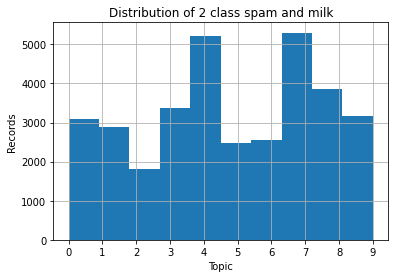

In [11]:
label_series = pd.Series(label_indices)

label_series.hist(bins=10)
plt.xticks(range(10))

plt.ylabel('Records')
plt.xlabel('Topic')
plt.title('Distribution of 2 class spam and milk')
plt.show()

# Feature extraction

In [12]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    features, label_indices, 
    test_size=test_ratio,
    stratify=label_indices
)

# TF - IDF

In [13]:
def get_TFIDF_feature_extractor(max_feature_dim=5000, ngram_range=(1,2)):
    
    tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=5000, ngram_range=ngram_range)
    
    return tfidf_vectorizer

In [14]:
# Extract TFIDF features
tfidf_extractor_1gram = get_TFIDF_feature_extractor(max_feature_dim=10000, ngram_range=(1,1))
tfidf_feature_train_1gram = tfidf_extractor_1gram.fit_transform(x_train)

tfidf_extractor_2gram = get_TFIDF_feature_extractor(max_feature_dim=10000, ngram_range=(1,2))
tfidf_feature_train_2gram = tfidf_extractor_2gram.fit_transform(x_train)

tfidf_extractor_3gram = get_TFIDF_feature_extractor(max_feature_dim=10000, ngram_range=(1,3))
tfidf_feature_train_3gram = tfidf_extractor_3gram.fit_transform(x_train)


# Model

In [15]:
# This function is to plot the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
def optimize_model_parameter(model, X_train, Y_train):
    '''
    Perform hyper parameter tuning for model
    '''
    best_model = model.fit(X_train, Y_train)
    #print(svm_grid_model.best_estimator_) 
    
    # Estimate the best accuracy
    train_accuracy = best_model.best_score_ *100
    print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )
    return best_model

def evaluate_model(model, X_test, Y_test):
    '''
    Initial evaluate model on test set
    '''
    # Predict topic indices in x_test
    y_test_hat = model.predict(x_test)

    # Estimate the testing accuracy
    test_accuracy = metrics.accuracy_score(y_test,y_test_hat)*100
    print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
    return test_accuracy

## SVM 

In [17]:
def get_SVM_model():
    '''
    Get linear SVM model and list of parameters
    '''
    # Initialize SVM model as a classifier
    svm_model = svm.SVC(probability=True) 

    # Define config for params
    param_grid = {'C': [ 100, 200], 
                  'kernel': ['linear', 'rbf']} 

    # Perform Grid search
    grid = GridSearchCV(
        svm_model, 
        param_grid, 
        refit = True, 
        verbose = 3, 
        cv=5,
        n_jobs=-1
    )
    
    return grid

### TF-IDF 

In [18]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, tfidf_feature_train_1gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", tfidf_extractor_1gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END ..............C=100, kernel=linear;, score=0.896 total time=19.2min
[CV 5/5] END ..............C=100, kernel=linear;, score=0.893 total time=19.2min
[CV 1/5] END ..............C=200, kernel=linear;, score=0.906 total time=19.4min
[CV 1/5] END ..............C=100, kernel=linear;, score=0.906 total time=19.4min
[CV 3/5] END ..............C=100, kernel=linear;, score=0.898 total time=19.5min
[CV 2/5] END ..............C=200, kernel=linear;, score=0.906 total time=19.5min
[CV 2/5] END ..............C=100, kernel=linear;, score=0.907 total time=19.6min
[CV 4/5] END ..............C=200, kernel=linear;, score=0.895 total time=21.9min
[CV 5/5] END ..............C=200, kernel=linear;, score=0.893 total time=22.1min
[CV 3/5] END ..............C=200, kernel=linear;, score=0.897 total time=22.3min
[CV 4/5] END .................C=100, kernel=rbf;, score=0.909 total time=55.2min
[CV 5/5] END .................C=100, kernel=rbf;,

91.98755924170617

In [19]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)


              precision    recall  f1-score   support

           0       0.95      0.92      0.94       616
           1       0.94      0.93      0.93       579
           2       0.86      0.82      0.84       364
           3       0.89      0.95      0.92       677
           4       0.85      0.89      0.87      1044
           5       0.95      0.95      0.95       496
           6       0.91      0.91      0.91       510
           7       0.99      0.99      0.99      1060
           8       0.95      0.90      0.93       774
           9       0.88      0.88      0.88       632

    accuracy                           0.92      6752
   macro avg       0.92      0.91      0.92      6752
weighted avg       0.92      0.92      0.92      6752



In [20]:
confus_mat

array([[ 569,    6,    4,    4,   15,    2,    0,    1,    1,   14],
       [   3,  537,    4,    6,   10,    4,    7,    0,    1,    7],
       [   4,    4,  299,   25,   15,    3,    2,    0,    0,   12],
       [   2,    3,   12,  642,    9,    0,    0,    2,    1,    6],
       [   6,    5,    5,   21,  932,    4,   22,    2,   23,   24],
       [   2,    2,    5,    1,    6,  473,    6,    0,    0,    1],
       [   0,    5,    3,    3,   24,    3,  462,    1,    3,    6],
       [   2,    3,    1,    1,    1,    2,    0, 1046,    2,    2],
       [   3,    3,    1,    3,   49,    3,    9,    3,  698,    2],
       [  10,    2,   12,   13,   33,    2,    1,    4,    2,  553]])

In [21]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, tfidf_feature_train_2gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", tfidf_extractor_2gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END ..............C=100, kernel=linear;, score=0.893 total time=16.4min
[CV 5/5] END ..............C=100, kernel=linear;, score=0.896 total time=16.4min
[CV 1/5] END ..............C=200, kernel=linear;, score=0.906 total time=16.5min
[CV 1/5] END ..............C=100, kernel=linear;, score=0.906 total time=16.5min
[CV 3/5] END ..............C=100, kernel=linear;, score=0.897 total time=16.6min
[CV 2/5] END ..............C=200, kernel=linear;, score=0.902 total time=16.6min
[CV 2/5] END ..............C=100, kernel=linear;, score=0.904 total time=16.7min
[CV 4/5] END ..............C=200, kernel=linear;, score=0.893 total time=16.5min
[CV 5/5] END ..............C=200, kernel=linear;, score=0.896 total time=16.5min
[CV 3/5] END ..............C=200, kernel=linear;, score=0.897 total time=16.7min
[CV 4/5] END .................C=100, kernel=rbf;, score=0.907 total time=39.8min
[CV 5/5] END .................C=100, kernel=rbf;,

92.20971563981043

In [22]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)
confus_mat

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       616
           1       0.94      0.93      0.94       579
           2       0.87      0.83      0.85       364
           3       0.90      0.95      0.92       677
           4       0.85      0.90      0.87      1044
           5       0.95      0.96      0.95       496
           6       0.91      0.91      0.91       510
           7       0.99      0.99      0.99      1060
           8       0.96      0.91      0.93       774
           9       0.89      0.88      0.88       632

    accuracy                           0.92      6752
   macro avg       0.92      0.92      0.92      6752
weighted avg       0.92      0.92      0.92      6752



array([[ 571,    5,    2,    3,   16,    2,    1,    1,    1,   14],
       [   3,  537,    4,    6,   11,    3,    7,    1,    1,    6],
       [   3,    4,  301,   24,   16,    4,    1,    0,    0,   11],
       [   2,    5,   12,  642,    8,    0,    0,    2,    0,    6],
       [   6,    7,    4,   21,  935,    4,   19,    2,   23,   23],
       [   2,    1,    6,    1,    5,  474,    6,    0,    0,    1],
       [   0,    2,    3,    3,   27,    3,  463,    0,    4,    5],
       [   2,    3,    1,    1,    2,    2,    0, 1046,    1,    2],
       [   3,    3,    1,    2,   43,    3,   10,    4,  703,    2],
       [   8,    2,   12,   13,   33,    2,    3,    3,    2,  554]])

In [23]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, tfidf_feature_train_3gram, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", tfidf_extractor_3gram),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END ..............C=100, kernel=linear;, score=0.893 total time=16.4min
[CV 5/5] END ..............C=100, kernel=linear;, score=0.894 total time=16.4min
[CV 1/5] END ..............C=200, kernel=linear;, score=0.907 total time=16.6min
[CV 1/5] END ..............C=100, kernel=linear;, score=0.907 total time=16.6min
[CV 3/5] END ..............C=100, kernel=linear;, score=0.898 total time=16.7min
[CV 2/5] END ..............C=100, kernel=linear;, score=0.906 total time=16.7min
[CV 2/5] END ..............C=200, kernel=linear;, score=0.904 total time=16.7min
[CV 4/5] END ..............C=200, kernel=linear;, score=0.892 total time=16.2min
[CV 5/5] END ..............C=200, kernel=linear;, score=0.894 total time=16.3min
[CV 3/5] END ..............C=200, kernel=linear;, score=0.897 total time=16.5min
[CV 4/5] END .................C=100, kernel=rbf;, score=0.907 total time=40.0min
[CV 5/5] END .................C=100, kernel=rbf;,

92.20971563981043

In [24]:
print(metrics.classification_report(y_test, y_test_hat))
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       616
           1       0.94      0.93      0.94       579
           2       0.87      0.83      0.85       364
           3       0.90      0.95      0.92       677
           4       0.85      0.89      0.87      1044
           5       0.96      0.96      0.96       496
           6       0.91      0.91      0.91       510
           7       0.99      0.99      0.99      1060
           8       0.96      0.91      0.93       774
           9       0.89      0.88      0.88       632

    accuracy                           0.92      6752
   macro avg       0.92      0.92      0.92      6752
weighted avg       0.92      0.92      0.92      6752



In [25]:
confus_mat

array([[ 572,    5,    2,    3,   16,    2,    0,    1,    1,   14],
       [   3,  538,    4,    6,   10,    3,    7,    1,    1,    6],
       [   3,    4,  302,   24,   16,    3,    1,    0,    0,   11],
       [   2,    5,   12,  642,    8,    0,    0,    2,    0,    6],
       [   6,    6,    4,   22,  933,    4,   19,    2,   24,   24],
       [   2,    1,    5,    1,    5,  475,    6,    0,    0,    1],
       [   0,    2,    3,    3,   27,    3,  462,    1,    3,    6],
       [   2,    3,    1,    1,    2,    2,    0, 1046,    1,    2],
       [   3,    3,    1,    2,   46,    3,   10,    3,  701,    2],
       [   8,    3,   12,   13,   31,    2,    3,    3,    2,  555]])